In [ ]:
!pip install split-folders

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print(tf.__version__)

2.6.3


In [ ]:
data_dir = '../input/all-brain-datset/all_dataset'
batch_size=32
image_size=224

In [ ]:
splitfolders.ratio(data_dir+ "/Training", output='brain-tumor-classification-mri', ratio=(0.8,0.1,0.1))

Copying files: 3264 files [00:11, 282.60 files/s]


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "./brain-tumor-classification-mri/train",
  shuffle=True,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 2609 files belonging to 4 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "./brain-tumor-classification-mri/val",
  shuffle=False,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 325 files belonging to 4 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  "./brain-tumor-classification-mri/test",
  shuffle=False,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 330 files belonging to 4 classes.


In [ ]:
class_names = test_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
def my_tf_round(x, decimals = 0):
    multiplier = tf.constant(10**decimals, dtype=x.dtype)
    return tf.round(x * multiplier) / multiplier

In [ ]:
normalization_layer1 = tf.keras.layers.Rescaling(1./255)
normalization_layer2 = tf.keras.layers.Normalization(mean=[0.5, 0.5, 0.5], 
                      variance=[np.square(0.5), 
                                np.square(0.5), 
                                np.square(0.5)])

-1.0 0.9906


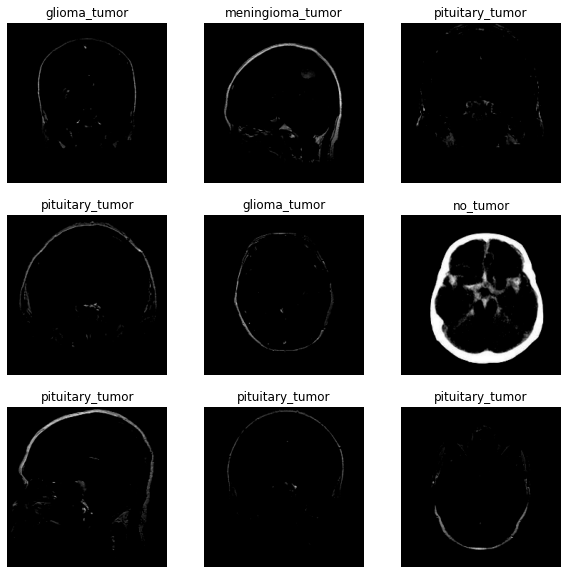

In [ ]:
train_ds_normalized = train_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(train_ds_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))
plt.figure(figsize=(10, 10))
for images, labels in train_ds_normalized:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

-1.0 0.9906


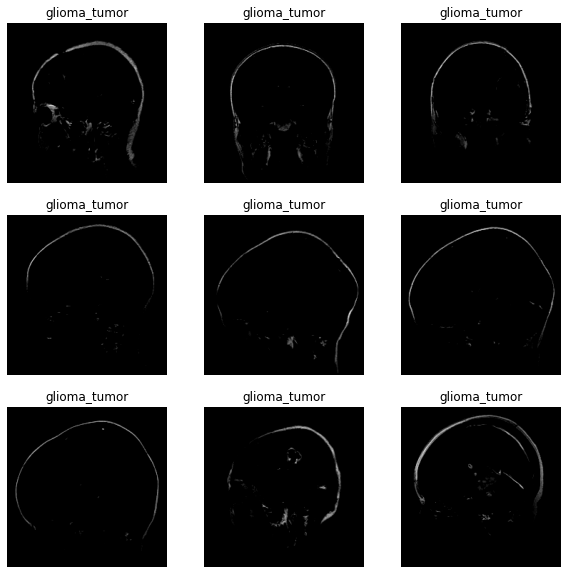

In [ ]:
val_ds_normalized = val_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(val_ds_normalized))

print(np.min(first_image), np.max(first_image))
plt.figure(figsize=(10, 10))
for images, labels in val_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

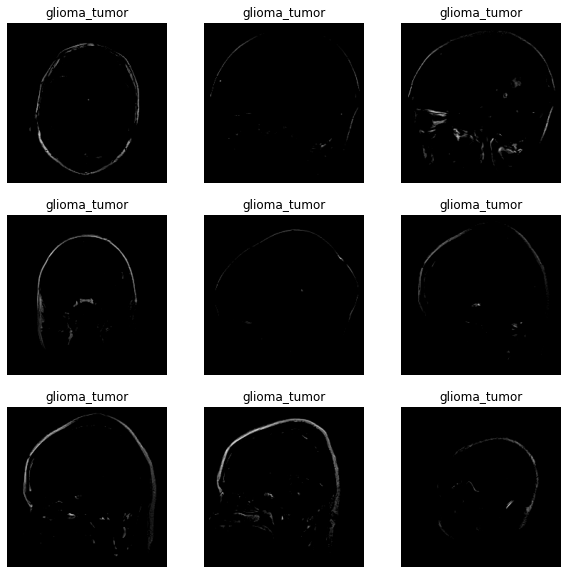

In [ ]:
test_ds_normalized = test_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(test_ds_normalized))
plt.figure(figsize=(10, 10))
for images, labels in test_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
y_test = [label for images, labels in test_ds_normalized for label in labels.numpy()]

In [ ]:
def display_report_and_matrix(y_pred, model):
    print(f'Test {model} Tensorflow and Keras')
   
    y_prediction = np.argmax(y_pred,axis=1)
    report = classification_report(y_test, y_prediction, target_names=class_names)
    print(f'{report}')

    fig, ax = plt.subplots(figsize=(7,7)) 
    ax.set_title(f'Confusion Matrix {model} Tensorflow and Keras')
    cm = confusion_matrix(y_test,y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax)

In [ ]:
def display_plot(history, model):
    plt.figure(figsize=(14, 8))
    tab_plot = [{
                  "id": 1,
                  "variables":['accuracy', 'val_accuracy'],
                  "labels":['Training Accuracy', 'Validation Accuracy'],
                  "legend":'lower right',
                  "title":f'Accuracy Tensorflow and Keras - {model}',
                  "ylabel":'Accuracy'
              },{ 
                  "id": 2,
                  "variables":['loss', 'val_loss'],
                  "labels":['Training Loss', 'Validation Loss'],
                  "legend":'upper right',
                  "title":f'Loss Tensorflow and Keras - {model}',
                  "ylabel":'Loss'
              }]
    epochs_range = range(25)
    for tab in tab_plot: 
          plt.subplot(1, 2, tab['id'])
          plt.plot(epochs_range, history.history[tab['variables'][0]], label=tab['labels'][0], marker='o', markerfacecolor='green',color='green')
          plt.plot(epochs_range, history.history[tab['variables'][1]], label=tab['labels'][1], marker='o', markerfacecolor='blue',color='blue')
          plt.legend(loc=tab['legend'])
          plt.title(tab['title'])
          plt.xlabel('Epochs')
          plt.ylabel(tab['ylabel'])
    plt.show()

In [ ]:
from tensorflow.keras.applications import MobileNetV2
mobilenet =  MobileNetV2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3),alpha=1)

In [ ]:
model = mobilenet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=mobilenet.input, outputs = model)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
print('Train Mobilenetv2 Tensorflow and Keras')
history_mobilenet_v2 = model.fit(train_ds_normalized,  validation_data=(val_ds_normalized), epochs=25)

Train Mobilenetv2 Tensorflow and Keras
Epoch 1/25
82/82 [==============================] - 19s 189ms/step - loss: 0.5168 - accuracy: 0.8176 - val_loss: 12.9459 - val_accuracy: 0.3415
Epoch 2/25
82/82 [==============================] - 15s 180ms/step - loss: 0.2253 - accuracy: 0.9329 - val_loss: 7.0698 - val_accuracy: 0.4308
Epoch 3/25
82/82 [==============================] - 15s 182ms/step - loss: 0.1840 - accuracy: 0.9467 - val_loss: 14.4335 - val_accuracy: 0.3323
Epoch 4/25
82/82 [==============================] - 15s 177ms/step - loss: 0.1272 - accuracy: 0.9582 - val_loss: 7.1239 - val_accuracy: 0.4615
Epoch 5/25
82/82 [==============================] - 16s 185ms/step - loss: 0.1417 - accuracy: 0.9578 - val_loss: 11.1093 - val_accuracy: 0.2554
Epoch 6/25
82/82 [==============================] - 15s 180ms/step - loss: 0.0950 - accuracy: 0.9709 - val_loss: 4.6680 - val_accuracy: 0.5785
Epoch 7/25
82/82 [==============================] - 16s 185ms/step - loss: 0.0769 - accuracy: 0.9743

Test Mobilenetv2 Tensorflow and Keras
                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.33      0.49        94
meningioma_tumor       0.77      0.79      0.78        95
        no_tumor       0.37      0.98      0.54        50
 pituitary_tumor       1.00      0.74      0.85        91

        accuracy                           0.67       330
       macro avg       0.77      0.71      0.66       330
    weighted avg       0.82      0.67      0.68       330



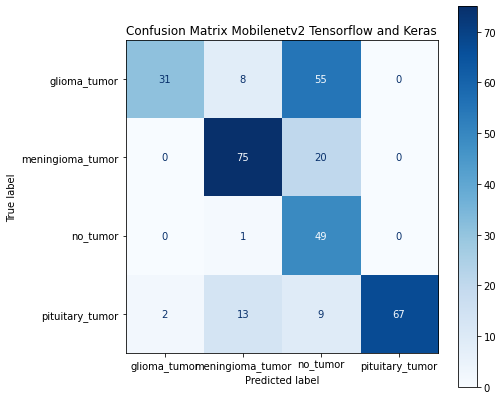

In [ ]:
y_pred_mobilenet_v2 = model.predict(test_ds_normalized)
display_report_and_matrix(y_pred_mobilenet_v2, 'Mobilenetv2')

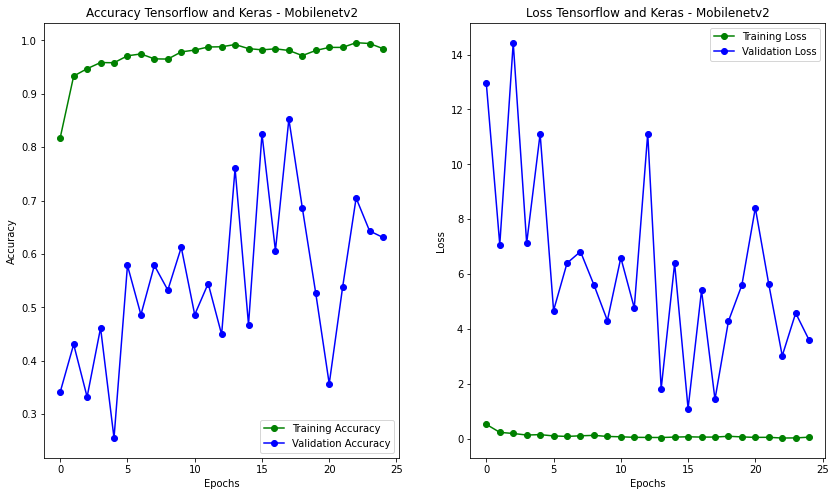

In [ ]:
display_plot(history_mobilenet_v2, 'Mobilenetv2')

In [ ]:
from tensorflow.keras.applications import DenseNet121 
dense =  DenseNet121(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
model_densenet = dense.output
model_densenet = tf.keras.layers.GlobalAveragePooling2D()(model_densenet)
model_densenet = tf.keras.layers.Dense(4,activation='softmax')(model_densenet)
model_densenet = tf.keras.models.Model(inputs=dense.input, outputs = model_densenet)

In [ ]:
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
print('Train DenseNet121 Tensorflow and Keras')
history_densenet = model_densenet.fit(train_ds_normalized, validation_data=val_ds_normalized, epochs=25)

Train DenseNet121 Tensorflow and Keras
Epoch 1/25
82/82 [==============================] - 31s 249ms/step - loss: 0.5041 - accuracy: 0.8214 - val_loss: 7.4828 - val_accuracy: 0.4000
Epoch 2/25
82/82 [==============================] - 18s 215ms/step - loss: 0.2806 - accuracy: 0.9023 - val_loss: 1.6766 - val_accuracy: 0.5477
Epoch 3/25
82/82 [==============================] - 19s 222ms/step - loss: 0.2167 - accuracy: 0.9283 - val_loss: 1.0469 - val_accuracy: 0.6646
Epoch 4/25
82/82 [==============================] - 18s 213ms/step - loss: 0.1393 - accuracy: 0.9529 - val_loss: 0.7307 - val_accuracy: 0.7846
Epoch 5/25
82/82 [==============================] - 19s 222ms/step - loss: 0.1282 - accuracy: 0.9540 - val_loss: 1.0590 - val_accuracy: 0.6923
Epoch 6/25
82/82 [==============================] - 18s 219ms/step - loss: 0.1430 - accuracy: 0.9471 - val_loss: 1.3877 - val_accuracy: 0.6277
Epoch 7/25
82/82 [==============================] - 19s 222ms/step - loss: 0.0702 - accuracy: 0.9755 - 

Test DenseNet121 Tensorflow and Keras
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.86      0.92        94
meningioma_tumor       0.89      0.98      0.93        95
        no_tumor       0.83      1.00      0.91        50
 pituitary_tumor       1.00      0.91      0.95        91

        accuracy                           0.93       330
       macro avg       0.93      0.94      0.93       330
    weighted avg       0.94      0.93      0.93       330



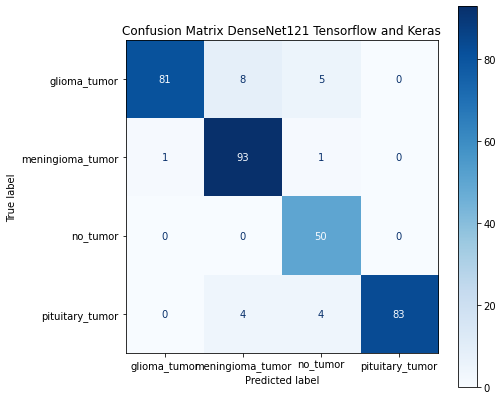

In [ ]:
y_pred_densenet = model_densenet.predict(test_ds_normalized)
display_report_and_matrix(y_pred_densenet, 'DenseNet121')

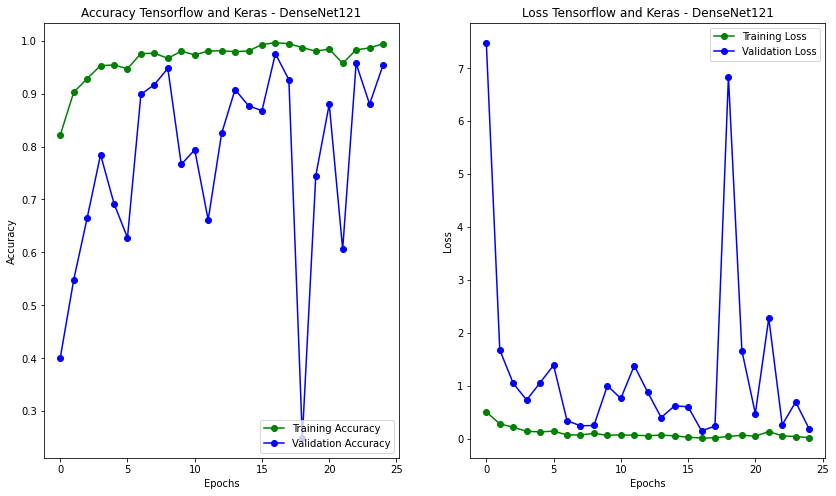

In [ ]:
display_plot(history_densenet, 'DenseNet121')

In [ ]:
from tensorflow.keras.applications import ResNet50  
resnet =  ResNet50(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model_resnet50 = resnet.output
model_resnet50 = tf.keras.layers.GlobalAveragePooling2D()(model_resnet50)

model_resnet50 = tf.keras.layers.Dense(4,activation='softmax')(model_resnet50)
model_resnet50 = tf.keras.models.Model(inputs=resnet.input, outputs = model_resnet50)

In [ ]:
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
print('Train Resnet50 Tensorflow and Keras')
history_resnet50 = model_resnet50.fit(train_ds_normalized, validation_data=val_ds_normalized, epochs=25)

Train Resnet50 Tensorflow and Keras
Epoch 1/25
82/82 [==============================] - 22s 202ms/step - loss: 0.7327 - accuracy: 0.7574 - val_loss: 8.3042 - val_accuracy: 0.1538
Epoch 2/25
82/82 [==============================] - 16s 187ms/step - loss: 0.3783 - accuracy: 0.8716 - val_loss: 11.3509 - val_accuracy: 0.1538
Epoch 3/25
82/82 [==============================] - 16s 192ms/step - loss: 0.2277 - accuracy: 0.9237 - val_loss: 3.0548 - val_accuracy: 0.1538
Epoch 4/25
82/82 [==============================] - 16s 190ms/step - loss: 0.1380 - accuracy: 0.9544 - val_loss: 2.0193 - val_accuracy: 0.1538
Epoch 5/25
82/82 [==============================] - 16s 191ms/step - loss: 0.1041 - accuracy: 0.9663 - val_loss: 1.9201 - val_accuracy: 0.1600
Epoch 6/25
82/82 [==============================] - 16s 187ms/step - loss: 0.1803 - accuracy: 0.9391 - val_loss: 2.3865 - val_accuracy: 0.2215
Epoch 7/25
82/82 [==============================] - 16s 191ms/step - loss: 0.0426 - accuracy: 0.9862 - va

Test ResNet50 Tensorflow and Keras
                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.93      0.94        94
meningioma_tumor       0.98      0.97      0.97        95
        no_tumor       0.91      0.98      0.94        50
 pituitary_tumor       1.00      1.00      1.00        91

        accuracy                           0.97       330
       macro avg       0.96      0.97      0.96       330
    weighted avg       0.97      0.97      0.97       330



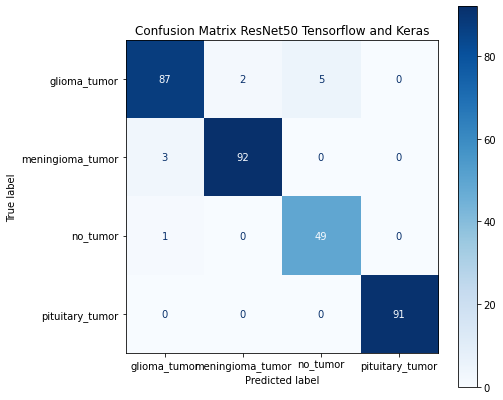

In [ ]:
y_pred_resnet50 = model_resnet50.predict(test_ds_normalized)
display_report_and_matrix(y_pred_resnet50, 'ResNet50')

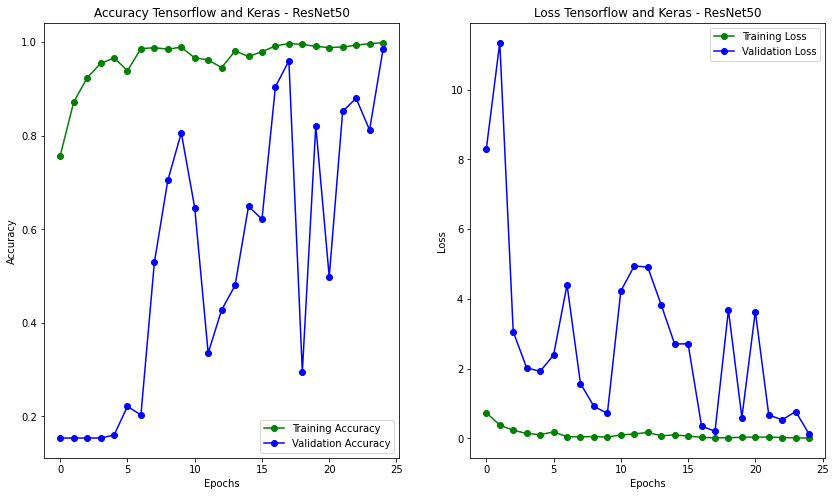

In [ ]:
display_plot(history_resnet50, 'ResNet50')